In [7]:
!pip install kagglehub --quiet
!pip install tensorflow --quiet


In [8]:
import kagglehub
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [9]:
# Download the dataset
path = kagglehub.dataset_download("mohamedmaher5/vehicle-classification")
print("Downloaded to:", path)

# Explore the folder to find actual image folder path
import os

for root, dirs, files in os.walk(path):
    print(f"\n📁 Folder: {root}")
    for d in dirs:
        print("   📂", d)


Downloaded to: /kaggle/input/vehicle-classification

📁 Folder: /kaggle/input/vehicle-classification
   📂 Vehicles

📁 Folder: /kaggle/input/vehicle-classification/Vehicles
   📂 Ships
   📂 Cars
   📂 Motorcycles
   📂 Bikes
   📂 Trains
   📂 Auto Rickshaws
   📂 Planes

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Ships

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Cars

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Motorcycles

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Bikes

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Trains

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Auto Rickshaws

📁 Folder: /kaggle/input/vehicle-classification/Vehicles/Planes


In [10]:
# Find the actual image folder dynamically (contains class subfolders)
def find_image_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        if len(dirs) > 1 and all(len(os.listdir(os.path.join(root, d))) > 0 for d in dirs):
            return root
    raise Exception("Could not find suitable image folder.")

image_dir = find_image_folder(path)
print("✅ Using image directory:", image_dir)


✅ Using image directory: /kaggle/input/vehicle-classification/Vehicles


In [11]:
batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    image_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    image_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 4470 images belonging to 7 classes.
Found 1117 images belonging to 7 classes.


In [12]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 22/140 ━━━━━━━━━━━━━━━━━━━━ 1:34 797ms/step - accuracy: 0.1823 - loss: 2.2679

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.2557 - loss: 2.0214 - val_accuracy: 0.7081 - val_loss: 1.0109
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 108s 773ms/step - accuracy: 0.6591 - loss: 1.0223 - val_accuracy: 0.8711 - val_loss: 0.5844
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 108s 772ms/step - accuracy: 0.8142 - loss: 0.6328 - val_accuracy: 0.8962 - val_loss: 0.4229
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 108s 774ms/step - accuracy: 0.8518 - loss: 0.4965 - val_accuracy: 0.9087 - val_loss: 0.3537
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 108s 775ms/step - accuracy: 0.8858 - loss: 0.3955 - val_accuracy: 0.9293 - val_loss: 0.2836
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 779ms/step - accuracy: 0.9011 - loss: 0.3314 - val_accuracy: 0.9239 - val_loss: 0.2617
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 780ms/step - accuracy: 0.9150 - loss: 0.2940 - val_accuracy: 0.9346 - val_loss: 0.2306
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 782ms/step - accuracy: 0.9239 - loss: 0.2546 

In [14]:
# Unfreeze all layers
base_model.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train further
fine_tune_epochs = 10
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10 + fine_tune_epochs,
    initial_epoch=history.epoch[-1]
)


Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 189s 991ms/step - accuracy: 0.8164 - loss: 0.5615 - val_accuracy: 0.9481 - val_loss: 0.1602
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 112s 803ms/step - accuracy: 0.9098 - loss: 0.2887 - val_accuracy: 0.9561 - val_loss: 0.1343
Epoch 12/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 111s 796ms/step - accuracy: 0.9317 - loss: 0.2234 - val_accuracy: 0.9642 - val_loss: 0.1148
Epoch 13/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 111s 794ms/step - accuracy: 0.9545 - loss: 0.1538 - val_accuracy: 0.9615 - val_loss: 0.1076
Epoch 14/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 778ms/step - accuracy: 0.9600 - loss: 0.1293 - val_accuracy: 0.9642 - val_loss: 0.0994
Epoch 15/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 778ms/step - accuracy: 0.9625 - loss: 0.1314 - val_accuracy: 0.9678 - val_loss: 0.0899
Epoch 16/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 775ms/step - accuracy: 0.9663 - loss: 0.1012 - val_accuracy: 0.9731 - val_loss: 0.0830
Epoch 17/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 111s 793ms/step - accuracy: 

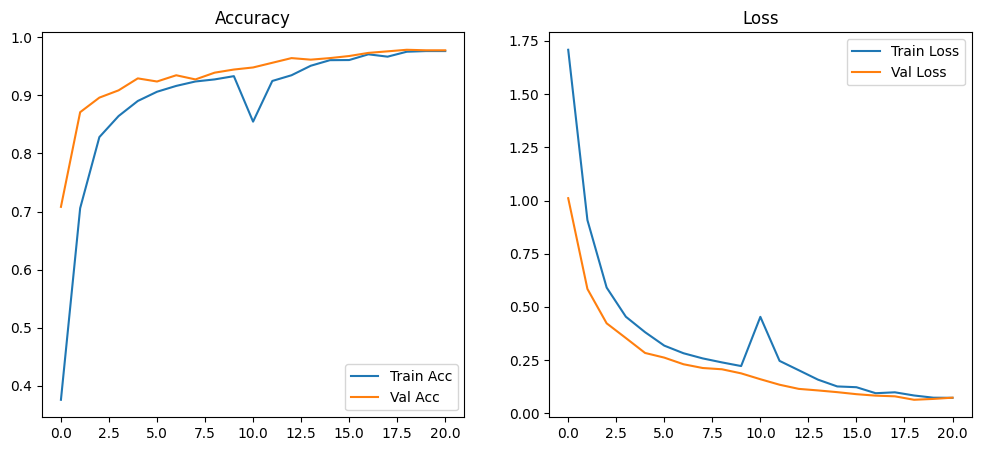

In [15]:
def plot_history(histories):
    plt.figure(figsize=(12, 5))

    acc = histories[0].history['accuracy'] + histories[1].history['accuracy']
    val_acc = histories[0].history['val_accuracy'] + histories[1].history['val_accuracy']

    loss = histories[0].history['loss'] + histories[1].history['loss']
    val_loss = histories[0].history['val_loss'] + histories[1].history['val_loss']

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history([history, history_finetune])
